# Analysis of timelapse data from Raspiscope

## Preliminaries
Before processing the images we need to set up the tools and load the data. We need to import several packages, so before running this notebook you should create an environment (conda or virtualenv) with matplotlib, numpy, and scikit-image, and jupyter. For example:

`conda create env -n raspiscope jupyter matplotlib numpy scikit-image`

and then activate it, e.g.:

`source activate raspiscope`

or select the conda env here in Jupyter.

### Modules
First import the standard tools, numpy and matplotlib. These are very well documented packages, more info can be found here:

http://www.matplotlib.org

http://www.numpy.org

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

We will use scikit-image to analyse and process images. There are many examples and tutorials here:

http://www.scitkit-image.org

In [3]:
import skimage 
from skimage import io, filters

### Loading images
First we specify a text string with the location and name of image files in the timelapse. We put a %d to represent the frame number, %04d means put the number with 4 digits. 

You should replace the text below with the location of the images on your computer. Using the % operator on the string we can then form any file name in the series:

In [9]:
#fname = "/Users/timrudge/RaspiScope/Timelapse060117/image_%04d.jpg"
#fname = "/Users/timrudge/RaspiScope/timelapse/timlap_3_%04d.jpg"
fname =  "D:\Dropbox\FTI\Raspiscope\Time lapse\TLE_G_7_3_17\image_%04d.jpg"
fname%(0)

'D:\\Dropbox\\FTI\\Raspiscope\\Time lapse\\TLE_G_7_3_17\\image_0000.jpg'

Lets see what frame 500 looks like. We use PyPlot to read the file into a numpy array. This is a 3-dimensional array (a grid of values) with dimensions x,y,c, with (x,y) position and c the color channel (red, green, blue). 

<img src="files/imagearray.png" width=256 height=256>

We can use PyPlot again to display the array, which interprets the array as a color image correctly.

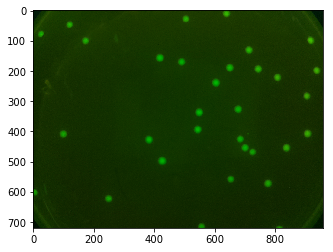

In [75]:
im = plt.imread(fname%300)
plt.imshow(im)

### Loading the time series
There are 3 channels in each image. For now we will just look at the green channel (c=1). We will load the green channel of all the images into a 3-dimensional array, with dimensions x, y, time. 

<img src="files/timeseriesarray.png" width=256 height=256>

First get the size of the image from the numpy array shape, the 3rd dimension size is 3 for R,G,B. We dont need it so use the "_" variable.

In [97]:
im.shape
w,h,_ = im.shape

As every image is a timepoint value, we should count the total number of images we have in the folder

In [24]:
import glob
path =  'D:\Dropbox\FTI\Raspiscope\Time lapse\TLE_G_7_3_17'
imageCount = len(glob.glob1(path,"*.jpg"))
print(imageCount)

388


Now we create a numpy array to hold the data and loop over the files, taking only channel 1 (green). There are a lot of time points in this series, so here we take every 10th frame:

In [77]:
xframes=2            #put here the step frames (e.g. 10 to use only ten to ten images)
nt = int(imageCount/xframes)
ims = np.zeros((w,h,nt))
for i in range(0,nt):
    im = plt.imread(fname%(i*xframes))
    ims[:,:,i] = im[:,:,1]              #replace the las number accor channel of your interest: 0=red, 1=green, 2=blue

Now we have a stack (x,y,t):

In [78]:
ims.shape

(720, 960, 194)

We could be interested in other channels or in the relation of the values between channnels.
Execute the botton module to save it into separated matrix:

In [98]:
imsR = np.zeros((w,h,nt))
imsG = np.zeros((w,h,nt))
imsB = np.zeros((w,h,nt))
for i in range(0,nt):
    im = plt.imread(fname%(i*xframes))
    imsR[:,:,i] = im[:,:,0]
    imsG[:,:,i] = im[:,:,1]
    imsB[:,:,i] = im[:,:,2]

## Analysis of time-lapse images
Now we have all the data loaded into a numpy array. To speed things up, take a subregion of the image to analyse. We do this by '[slicing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html)' the array:

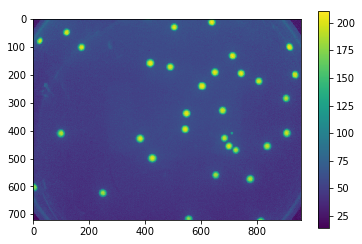

In [79]:
imssub = ims #[200:600,200:600,:]
plt.imshow(imssub[:,:,-1])
plt.colorbar()

### Mean dynamics over image domain
We can get some information by looking just at the variation in total image intensity in the time-series. Do this by taking the sum of the (x,y,t) stack over the first two dimensions (0,1):

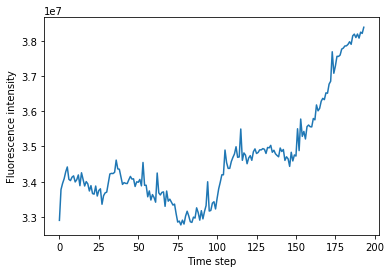

In [80]:
sumims = imssub.sum(axis=(0,1))
plt.plot(sumims)
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')

### Identifying colonies
The colonies vary in brightness over the experiment but do not move. So we can take the sum of intensity of each pixel over time, and use it to locate colonies reliably:

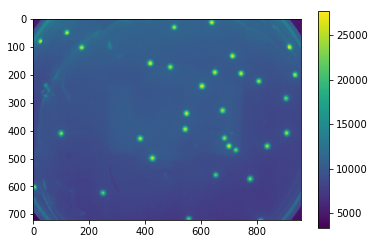

In [81]:
ims_sum = imssub.sum(axis=2)
plt.imshow(ims_sum)
plt.colorbar()

With any image its essential to remove noise before analysis, here with a [Gaussian filter](http://scikit-image.org/docs/dev/api/skimage.filters.html#skimage.filters.gaussian). Normalisation to (0,1) is also convenient:

In [82]:
from skimage.filters import gaussian
simsub = gaussian(ims_sum, 2)
nsimsub = (simsub-simsub.min())/(simsub.max()-simsub.min())

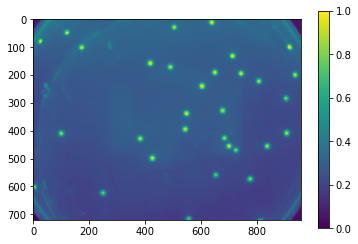

In [83]:
plt.imshow(nsimsub)
plt.colorbar()

#### Blob detection
Scikit-image provides several functions to detect Gaussian-like features ([blobs](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html)). We apply one of these ([blob_log](http://scikit-image.org/docs/dev/api/skimage.feature.html#skimage.feature.blob_log)) to the smoothed sum of intensity, and it returns a list of position (x,y) and width (standard deviation):

In [84]:
import skimage.feature as skfeat
A = skfeat.blob_log(nsimsub, min_sigma=1.0, max_sigma=10.0, num_sigma=100, threshold=0.25, overlap=0.8)

In [85]:
print (A.shape)
print (A[0:4,:])

(31, 3)
[[  12.          640.            6.54545455]
 [  29.          506.            6.81818182]
 [  48.          121.            6.54545455]
 [  79.           26.            5.81818182]]


In [86]:
A[0,1]

640.0

The array A now contains the location of probable colonies. We can check by showing the image and plotting markers on top at each location contained in A:

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


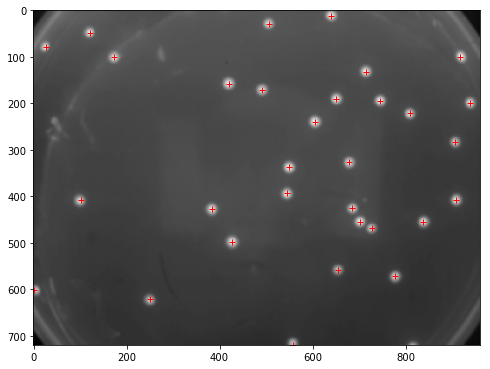

In [87]:
plt.figure(figsize=(8,8))
plt.imshow(nsimsub, cmap='gray')
plt.hold(True)
for i in range(len(A)):
    plt.plot(A[i,1],A[i,0],'r+')

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


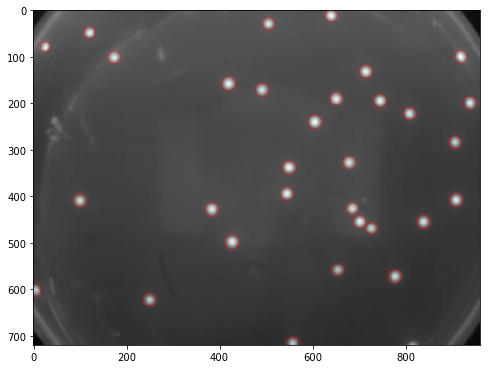

In [52]:
plt.figure(figsize=(8,8))
plt.imshow(nsimsub, cmap='gray')
plt.hold(True)
for i in range(len(A)):
    circle = plt.Circle((A[i,1], A[i,0]), 2*A[i,2], color='r', fill=False , lw=0.5)
    fig = plt.gcf()
    ax = fig.gca()
    ax.add_artist(circle)

### Time dynamics of colonies
Now we have estimated colony location (and size) we can analyse the dynamics of fluorescence and growth. First to distinguish cell fluorescence from media and background light, we select an empty region of the plate (by eye) and take the mean value in each frame as the background:

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


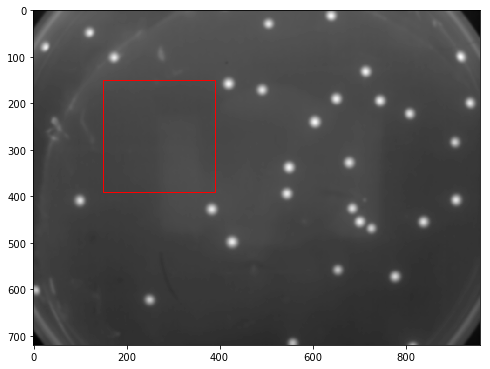

In [88]:
b_regX=[150,240]
b_regY=[150,240]
plt.figure(figsize=(8,8))
plt.imshow(nsimsub, cmap='gray')
plt.hold(True)
rectangle = plt.Rectangle((b_regY[0],b_regX[0]),b_regY[1],b_regX[1], color='r', fill=False , lw=1)
fig = plt.gcf()
ax = fig.gca()
ax.add_artist(rectangle)

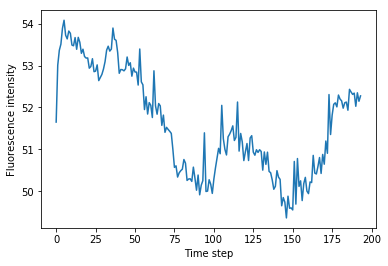

In [89]:
#bg = imssub[300:400,0:100,:].mean(axis=(0,1))
bg = imssub[b_regX[0]:b_regX[1],b_regY[0]:b_regY[1],:].mean(axis=(0,1))
plt.plot(bg)
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')

To restrict image analysis for each colony, we can extract a region at each location, with size given by the Gaussian width (x2 = 2 standard deviations). Here we put the image series into a dict indexed by colony. We also subtract the background estimate from each time series.

In [90]:
rois = {}
for i in range(len(A)):
    x = A[i,0]
    y = A[i,1]
    r = 2*A[i,2]
    rois[i] = imssub[x-r:x+r,y-r:y+r,:]-bg
    

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Now we can plot the total fluoresence in the region of each colony:

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  app.launch_new_instance()
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


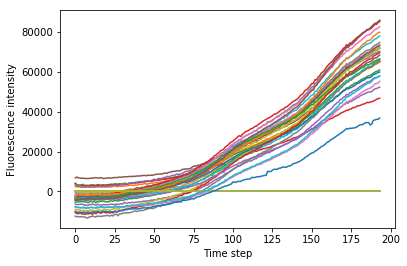

In [102]:
for i in range(len(A)):
    plt.plot(rois[i].sum(axis=(0,1)))
    plt.hold(True)
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')
#plt.legend(['Colony %d'%i for i in range(len(A))])

#### Colony class identification by color
(useful for images with different class of colonies, with different characteristic colors)

In [125]:
#background computation
bgR = imsR[b_regX[0]:b_regX[1],b_regY[0]:b_regY[1],:].mean(axis=(0,1))
bgG = imsG[b_regX[0]:b_regX[1],b_regY[0]:b_regY[1],:].mean(axis=(0,1))
bgB = imsB[b_regX[0]:b_regX[1],b_regY[0]:b_regY[1],:].mean(axis=(0,1))

In [129]:
roisR = {}
roisG = {}
roisB = {}
for i in range(len(A)):
    x = A[i,0]
    y = A[i,1]
    r = 2*A[i,2]
    roisR[i] = imsR[x-r:x+r,y-r:y+r,:]-bgR
    roisG[i] = imsG[x-r:x+r,y-r:y+r,:]-bgG
    roisB[i] = imsB[x-r:x+r,y-r:y+r,:]-bgB

    #replace less than 1 values to avoid problems    
    roisR[i][roisR[i] < 1] = 1
    roisG[i][roisG[i]< 1] = 1
    roisB[i][roisB[i] < 1] = 1

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Prosimio\Anacon

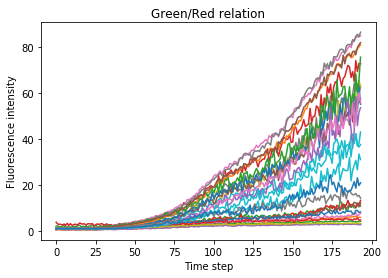

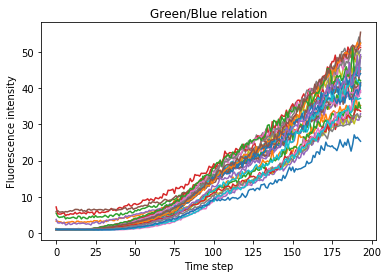

In [132]:
fig= plt.figure()
for i in range(len(A)):
    plt.plot(roisG[i].sum(axis=(0,1))/roisR[i].sum(axis=(0,1)))
    plt.hold(True)
plt.title('Green/Red relation')
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')

fig= plt.figure()
for i in range(len(A)):
    plt.plot(roisG[i].sum(axis=(0,1))/roisB[i].sum(axis=(0,1)))
    plt.hold(True)
plt.title('Green/Blue relation')
plt.xlabel('Time step')
plt.ylabel('Fluorescence intensity')

#### Colony radius growth
We have the location and some kind of size estimate based on the total fluorescence of each colony over the time-lapse. We would like to know the size of the colony in each frame; from this we can compute the growth rate.

One way to do this is the find Gaussian blobs in each of the image regions of the colony, for each frame of the time-lapse. Then assume that the first (only?) blob detected is the colony we are interested in. This is very slow, there may be a faster way since we can assume a single Gaussian in each image region. Anyway for now it works ok.

The following loop finds blobs and stores the width in each frame. The result is a dict containing the size at each time point for every colony.

In [92]:
R = {}
for k in range(len(A)):
    R[k] = np.zeros((nt,))
    for i in range(nt):
        troi = rois[k][:,:,i].astype(np.float32)
        if len(troi):
            ntroi = (troi-troi.min())/(troi.max()-troi.min())
            AA = skfeat.blob_log(ntroi, min_sigma=1.0, max_sigma=10.0, num_sigma=200, threshold=0.25, overlap=0.8)
            if len(AA)>0:
                R[k][i] = AA[0,2]

ValueError: zero-size array to reduction operation minimum which has no identity

Since the colony is roughly circular and flat, an estimate of volume is $R^2$. Lets plot this for some colonies. Plotting the log is useful because the slope is the relative growth rate. We can see the colonies slow their growth during the experiment.

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


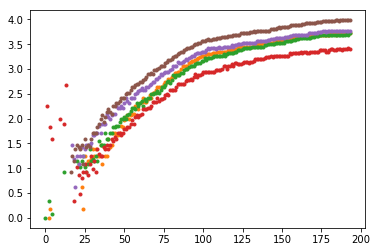

In [93]:
idx = [0,1,2,3,4,9]
for i in idx:
    r = R[i]
    plt.plot(np.log(r*r), '.')
    plt.hold(True)

#### Check the radius estimate
To see how well the colony size is estimated, we can compare to the profile of a colony in a slice of its image region. The radius (red line) should give the border of the colony.

C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
C:\Users\Prosimio\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
C:\Users\Prosimio\Anaconda3\lib\site-packages\matplotlib\rcsetup.py:152: UserWarning: axes.hold is deprecated, will be removed in 3.0
  warnings.warn("axes.hold is deprecated, will be removed in 3.0")


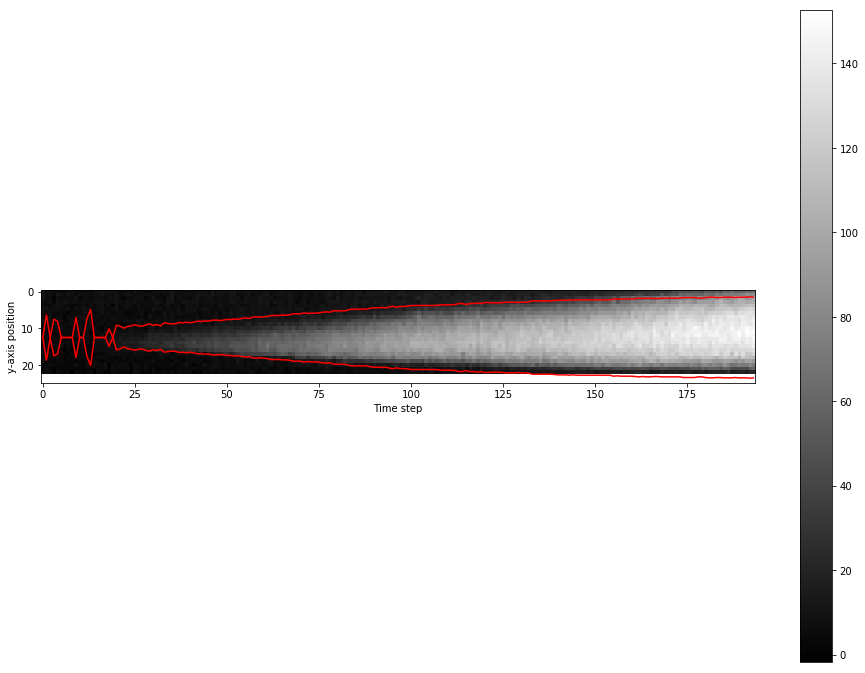

In [94]:
idx = 3
plt.figure(figsize=(16,12))
w,h,d = rois[idx].shape
plt.imshow(rois[idx][w/2+1,:,:], interpolation='none', cmap='gray')
plt.colorbar()
plt.hold(True)
plt.plot(-R[idx]*2+h/2+1,'r')
plt.plot(R[idx]*2+h/2+1,'r')
plt.xlabel('Time step')
plt.ylabel('y-axis position')

### Dynamics plotting
A simple way to view dynamics is a movie, plotting each frame successively. To do this we have to turn off inline plotting so that a new window will open. Also create the directory to place output images. These can then be converted into a video (e.g. using Fiji/ImageJ).

Using matplotlib backend: Qt5Agg


ValueError: zero-size array to reduction operation maximum which has no identity

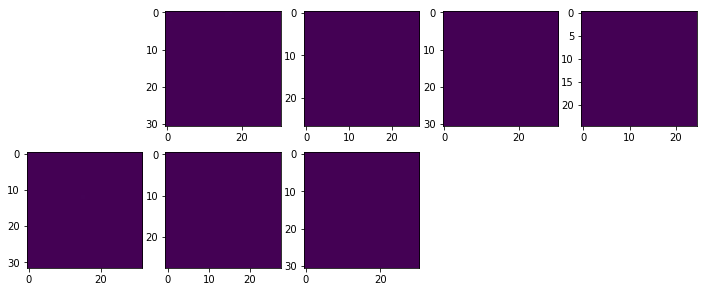

In [95]:
%matplotlib auto
plt.figure(figsize=(12,10))    
for i in range(nt):
    for idx in range(20):
        if len(rois[idx]):
            mx = np.max(rois[idx+20])
            plt.subplot(4,5,idx+1)
            #plt.imshow(rois[idx+20][:,:,-1], interpolation='none', vmin=0, vmax=mx)
            #plt.colorbar()
            roi = rois[idx+20][:,:,i]
            plt.imshow(roi, interpolation='none', vmin=0, vmax=255)
    # Uncomment here to save figures as images
    #plt.savefig('AnalysisOutput/rois2/rois_step%d.png'%(i))
    #plt.title('Colonies 1-20')
    plt.pause(0.1)
%matplotlib inline

### Parameter estimation from data
We now have information about sub-populations of bacteria (colonies) on the same plate. The fluorescence in each region of interest estimates the time varying fluorescent protein level in each colony. The radius (or $R^2$) approximates the size of each sub-population (colony) and so is similar to optical density (OD) in a bulk plate-reader experiment. 

Lets write a simple model of fluorescent protein expression from a single cell:

\begin{equation}
\frac{dF}{dt} = k(t) - (\mu(t) + \delta(t))F
\end{equation}

where $F$ is the cell's fluorescent protein concentration, which is produced at time-varying rate $k(t)$. The cell grows at relative rate $\mu(t)=(1/V)dV/dt$ ($V=$volume) causing dilution. The protein is degraded at rate $\delta(t)$.

For the proteins we are using we will assume that $\delta(t)=0$ for all times. We measure the total fluorescence intensity, which is the concentration $F$ multiplied by the total volume of the colony $V_{tot} \approx R^2$. Hence,

\begin{equation}
I(t) = F(t)V(t) \approx F(t)R^2(t)
\end{equation}

From these equations it is possible to derive:

\begin{equation}
k(t) = \frac{1}{V(t)}\frac{dI}{dt}
\end{equation}

Lets get $V$ and $I$ from our data:

In [26]:
# Approximate volume as R^2
V = {}
for idx,r in R.iteritems():
    V[idx] = r*r
    
# Get total fluorescence intensity for each colony, summing over all pixels in the region
I = {}
for idx,roi in rois.iteritems():
    I[idx] = roi.sum(axis=(0,1))

Plot an example colony:

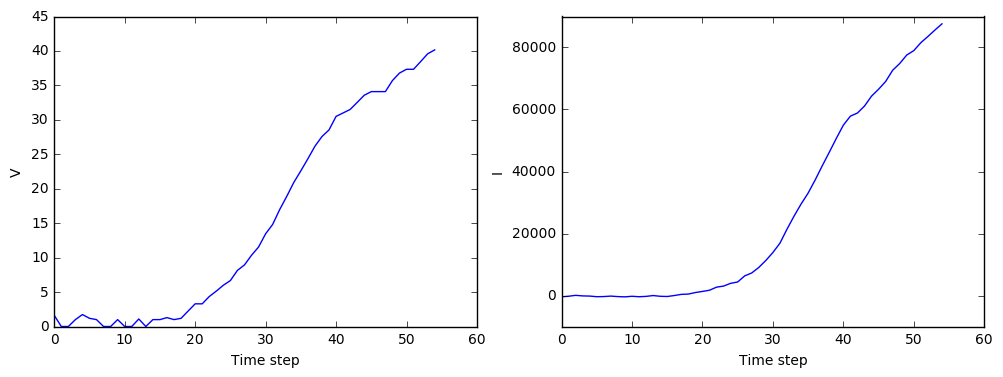

In [27]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(V[1])
plt.xlabel('Time step')
plt.ylabel('V')
plt.subplot(1,2,2)
plt.plot(I[1])
plt.xlabel('Time step')
plt.ylabel('I')

Now we can use a simple approach to estimate $k(t)$. Since $dI/dt \approx \Delta I / \Delta t$, we can compute:

\begin{equation}
k(t) \propto \frac{I(t)-I(t-1)}{V(t)}
\end{equation}

/Users/timrudge/miniconda/envs/raspiscope/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in divide


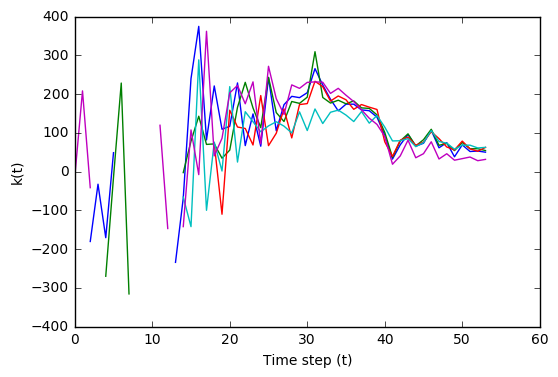

In [28]:
colonies = [1,2,3,4,10]
for idx in colonies:
    intensity = I[idx]
    volume = V[idx][1:]
    delta_I = np.diff(intensity)
    k = delta_I/volume
    plt.plot(k)
    plt.hold(True)
plt.xlabel('Time step (t)')
plt.ylabel('k(t)')

### Data smoothing

This is very noisy because we have taken a simple difference as an estimate of the time derivative, which amplifies the noise in the data. One way to address this is to fit a smooth curve through the fluorescence data (I), which we can assume varies (mostly) monotonically (increasing). We do not expect sharp bursts or other biologically caused high frequencies in this data because it is an average of many cells.

In [29]:
from scipy.interpolate import UnivariateSpline

In [101]:
x = range(len(I[2]))

In [139]:
dIdt={}
colonies = range(len(A)) #[1,2,3,4,5,6,7]
for idx in colonies:
    spl = UnivariateSpline(x,I[idx])
    spl.set_smoothing_factor(1e7)
    dIdt[idx] = spl.derivative(1)(x)
    

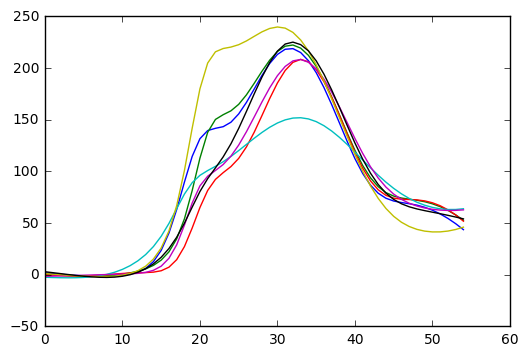

In [147]:
mu={}
ksmooth={}
colonies = [1,2,3,4,5,7,8]
plt.figure()
plt.hold(True)
for idx in colonies:
    spl = UnivariateSpline(x[20:],V[idx][20:])
    spl.set_smoothing_factor(10)
    mu[idx] = spl.derivative(1)(x)/spl(x)
    ksmooth[idx] = dIdt[idx]/spl(x)
    plt.plot(x, ksmooth[idx])

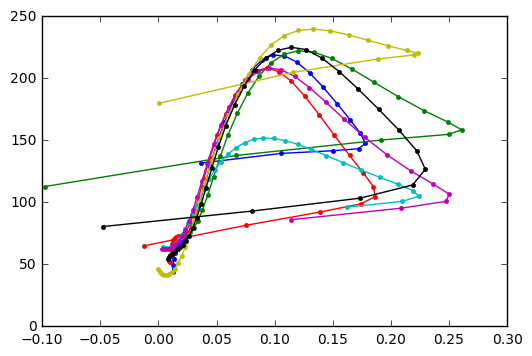

In [152]:
for idx in colonies:
    plt.plot(mu[idx][20:], ksmooth[idx][20:], '.-')